# Laboratory 4: Getting started with Pytorch

In this laboratory we will begin working with Pytorch to implement and train complex, nonlinear models for supervised learning problems. You will notice many similarities between Numpy and Pytorch -- this is deliberate, but it can cause some confusion and for many things we will have to convert back and forth between Numpy arrays and Pytorch tensors.

## Part 0: First steps

**Important**: You **must** install Pytorch in your Anaconda environment for this laboratory. The easiest way to do this is to just install the CPU version of Pytorch like this:

```
conda activate FML
conda install -c pytorch pytorch torchvision
```

**Note**: If you have an Nvidia GPU on your computer you can also install the GPU-enabled version of Pytorch which will **greatly** improve performance for more complex models and larger datasets. However, it can be very hard to get all of the versions of the required libraries to match correctly... During the laboratory we can look at it together if you are interested.

After installing Pytorch, use the next cell to verify that the installation is working. If it prints a 3x3 sensor, we're good to go.

In [2]:
# We're still going to need numpy and matplotlib.
import numpy as np
import matplotlib.pyplot as plt

# Verify that pytorch is working.
import torch

# Select a random tensor 3 by 3 in PyTorch to verify if it is working 
random_number = torch.randn((3, 3))
print(random_number)

tensor([[ 0.3834, -1.2433, -1.0787],
        [ 0.4973,  1.1934, -0.2174],
        [ 0.1920, -1.0976, -0.0052]])


In [3]:
# Check available device ("CUDA" or "CPU")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device type: {device}")

Device type: cpu


## Part 1: Dataset preparation

We will work with the venerable MNIST dataset of handwritten digits in this laboratory. The `torchvision` library provides classes for a bunch of standard datasets, including MNIST. These classes automatically download and prepare the dataset for use.

In [4]:
# Download and load the MNIST (Modified National Institute of Standards and Technology database) dataset.
from torchvision.datasets import MNIST
import torchvision

# Load the MNIST training and test splits.
ds_train = MNIST(
    root='./data', 
    download=True, 
    train=True
)

ds_test  = MNIST(
    root='./data', 
    download=True, 
    train=False
)

**Commento**: Il database MNIST (*Modified National Institute of Standards and Technology database*) è un database di immagini che rappresentano delle cifre numeriche scritte a mano a dagli impiegati dell'ufficio censimento degli Stati Uniti (*American Census Bureau*). Tale databse contiene 60,000 immagini per l'addestramento (*training*) e 10,000 immagini per la verifica (*test*).

### Exercise 1.1: Exploratory data analysis

Spend some time inspecting the `ds_train` and `ds_test` data structures in order to get a feel for the data. What is the format? How big are the images? How many are there? What about the range of pixel values? Where are the labels for images?

Remember that one of the best ways to explore is to *visualize*.

In [5]:
# Show train
print(ds_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train


In [6]:
print(ds_test)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


In [36]:
number_images, height_pixel, width_pixel = ds_train.data.size()
print(f"Number of images is {number_images}, where each image is {height_pixel} pixel in height and {width_pixel} pixel in width.")

Number of images is 60000, where each image is 28 pixel in height and 28 pixel in width.


In [90]:
print("Train labels")
print(ds_train.targets)
print(f"Number of train labels: {len(ds_train.targets)}")

Train labels
tensor([5, 0, 4,  ..., 5, 6, 8])
Number of train labels: 60000


In [89]:
print("Test labels")
print(ds_test.targets)
print(f"Number of test labels: {len(ds_test.targets)}")

Test labels
tensor([7, 2, 1,  ..., 4, 5, 6])
Number of test labels 10000


**Commento**: come si può vedere dall'output del metodo print, il traning del dataset MNIST contiene 60.000 immagini (di cifre scritte a mano) dove ogni immagini ha una dimensione di 28 x 28 pixel. Nelle immagini successive si può notare che ogni immagine è una cifra scritta a mano in scala di grigi con dimensione di 28 x 28 pixel.

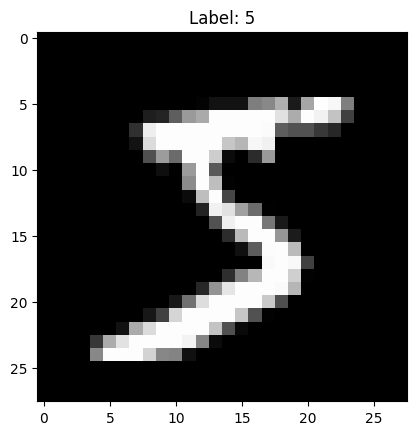

In [37]:
sample_index = 0
plt.imshow(ds_train.data[sample_index], cmap='gray')
plt.title('Label: %i' % ds_train.targets[sample_index])
plt.show()

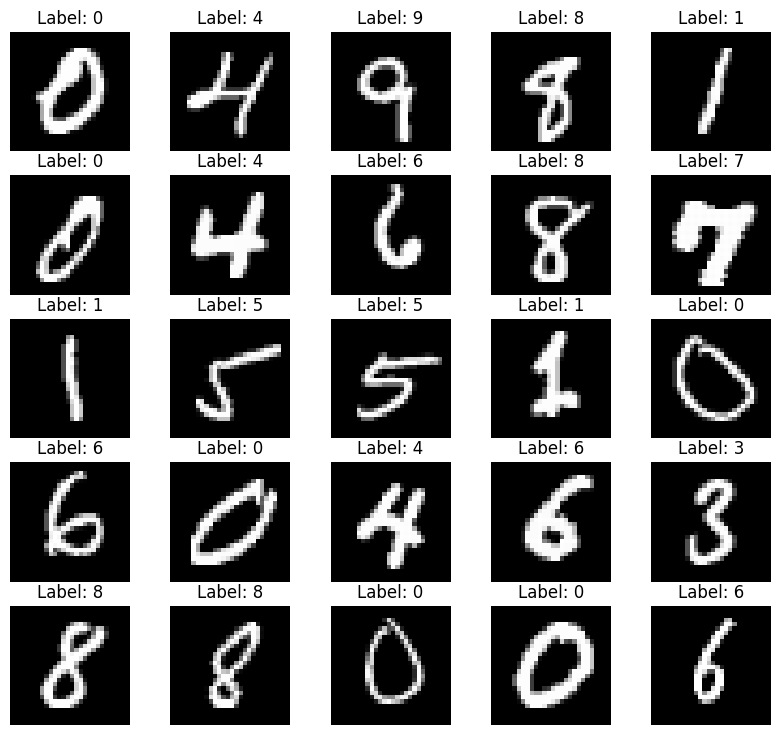

In [39]:
figure = plt.figure(figsize=(10, 9))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_index = torch.randint(len(ds_train), size=(1,)).item()
    img, label = ds_train[sample_index]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

### Exercise 1.2: Dataset conversion and normalization

+ **Datatype Conversion**:
The first thing we need to do is convert all data tensors to `torch.float32` -- this is fundamental as it is extremely inconvenient to work with `uint8` data. Using 32-bit floating point numbers is a compromise between precision and space efficiency.
The `torch.Tensor` class has a very useful method `to()` for performing datatype and device (e.g. to GPU) conversions. Check out the [documentation here](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch-tensor-to).

+ **Normalization**:
Next, we need to correct the inconvenient range of [0, 255] for the pixel values. You should *subtract* the mean intensity value and divide by the standard deviation in order to *standardize* our data. **Important**: Think *very carefully* about *which* split you should use to compute the pixel statistics for standardization.

+ **Reshaping**: Is the data in an appropriate format (i.e. shape) for the training the models we know? Think about whether (and how) to fix this if needed. 

**What to do**: In the cell below you should perform this sequence preprocessing operations on the `ds_train.data` and `ds_test.data` tensors. 

**Commento**: il seguente esempio si serve di una immagine per comprendere meglio la procedura di coversione e di normalizzazione proposta a lezione.

In [100]:
print(f"Number of train images: {len(ds_train.data)}.\n")

# (1) Datatype Conversion (example with one image)
print("(1) Datatype Conversion (example with one image):\n")

index_image = 128
# get one image
image_train = ds_train.data[index_image]


print("Original Training image in uint8.\n")
print(f"Size original: {image_train.size()}")
print("")
print(image_train)

print("")
print("Datatype Conversion of Training images: uint8 -> float32 and flatten into a one-dimensional tensor.\n")
image_train_conv = ds_train.data[index_image].to(torch.float32).flatten(-2)
print(f"Size converted: {image_train_conv.size()}")
print("")
print(image_train_conv)

# (2) Normalization (example with one image)
print("")
print("(2) Normalization (example with one image):\n")
mean = image_train_conv.mean()
print(f"Mean train: {mean}")
std = image_train_conv.std()
print(f"Standard deviation train: {std}\n")
image_train_conv -= mean
image_train_conv /= std
print("Image normalized:\n")
print(image_train_conv)

Number of train images: 60000.

(1) Datatype Conversion (example with one image):

Original Training image in uint8.

Size original: torch.Size([28, 28])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          73, 253, 253,  63,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  

**Commento**: nel codice seguente si esegue le operazioni precedenti per tutto il dataset.

In [112]:
# (1) Datatype Conversion
Xs_train = ds_train.data.to(torch.float32).flatten(-2)
Xs_test = ds_test.data.to(torch.float32).flatten(-2)

# (2) Normalization:
mean_train = Xs_train.mean()
std_train = Xs_train.std()
print(f"Before normalization, Mean: {Xs_train.mean()} - Standard Deviation {Xs_train.std()} of the Train set.")

# Standardize train set.
Xs_train -= mean_train
Xs_train /= std_train
print(f"After normalization, Mean: {Xs_train.mean()} - Standard Deviation {Xs_train.std()} of the Train set.")
print("")

# Standardize test set.
print(f"Before normalization, Mean: {Xs_test.mean()} - Standard Deviation {Xs_test.std()} of the Test set.")
Xs_test -= mean_train
Xs_test /= std_train
print(f"After normalization, Mean: {Xs_test.mean()} - Standard Deviation {Xs_test.std()} of the Test set.")
print("")

# Extract train and test labels.
ys_train = ds_train.targets
ys_test  = ds_test.targets
print(f"Labels train: {ys_train}")
print(f"Labels test: {ys_test}")

Before normalization, Mean: 33.318424224853516 - Standard Deviation 78.56748962402344 of the Train set.
After normalization, Mean: -5.1236316522818015e-08 - Standard Deviation 1.0 of the Train set.

Before normalization, Mean: 33.79122543334961 - Standard Deviation 79.17247009277344 of the Test set.
After normalization, Mean: 0.006017743144184351 - Standard Deviation 1.0077000856399536 of the Test set.

Labels train: tensor([5, 0, 4,  ..., 5, 6, 8])
Labels test: tensor([7, 2, 1,  ..., 4, 5, 6])


### Exercise 1.3: Subsampling the MNIST dataset.

MNIST is kind of big, and thus inconvenient to work with unless using the GPU. For this laboratory we will use a smaller subset of the dataset for training to keep memory and computation times low.

Modify `ds.train` to use only a subset of, say, 10000 images sampled from the original data. Make sure to select the correct corresponding targets.


In [127]:
# Randomly sample 10000 training images.


seed = 24325
torch.manual_seed(seed) # Set random seed.

# set subset dimension
num_train = 10000

# select num_train random indeces. First we apply a permutation on the 60000 elements in the train set 
# and then take the first num_train 
I = torch.randperm(Xs_train.shape[0])[:num_train]
print(f"Number of index: {len(I)}")

# subset Xs_train 
Xs_train_small = Xs_train[I]
ys_train_small = ys_train[I]

index_num_print = 10
print(f"Print the first {index_num_print} index:")
print(I[:index_num_print])

Number of index: 10000
Print the first 10 index:
tensor([54432, 54862, 57056, 54723, 25502, 56406, 43474, 51312, 46127, 41635])


In [131]:
print("Original set:")
Xs_train.shape, ys_train.shape

Original set:


(torch.Size([60000, 784]), torch.Size([60000]))

In [133]:
print("Subset:")
Xs_train_small.shape, ys_train_small.shape

Subset:


(torch.Size([10000, 784]), torch.Size([10000]))

## Establishing a stable baseline

In this exercise you will establish a reliable baseline using a classical approach. This is an important step in our methodology in order to judge whether our Deep MLP is performing well or not.

### Exercise 2.1: Establish the stable baseline

Train and test your stable baseline to estimate the best achievable accuracy using classical models.

**Tip**: Don't do any extensive cross-validation of your baseline (for now). Just fit a simple model (e.g. a linear SVM) and record the accuracy.



In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

linearSVC = 


In [126]:
# Your code here.
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

svc = QuadraticDiscriminantAnalysis()
svc.fit(Xs_train_small, ys_train_small)

/home/bagdanov/software/miniconda3/envs/FML/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [127]:
(svc.predict(Xs_test) == ys_test.numpy()).mean()

0.1963

In [128]:
from sklearn.metrics import classification_report
print(classification_report(svc.predict(Xs_test), ys_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.22      0.26      0.24       891
           3       0.03      0.83      0.06        36
           4       0.00      0.22      0.01        18
           5       0.00      0.27      0.01        15
           6       0.06      0.93      0.11        59
           7       0.66      0.63      0.64      1082
           8       0.98      0.12      0.22      7892
           9       0.01      1.00      0.01         7

    accuracy                           0.20     10000
   macro avg       0.20      0.43      0.13     10000
weighted avg       0.87      0.20      0.26     10000


/home/bagdanov/software/miniconda3/envs/FML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bagdanov/software/miniconda3/envs/FML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bagdanov/software/miniconda3/envs/FML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

## Part 3: Training some deep models (finally)

Now we will finally train some deep models (Multilayer Perceptrons, to be precise). Since the dataset is a bit too large to use batch gradient descent, we will first need to setup a `torch.utils.data.DataLoader` for our training data. A `DataLoader` breaks the dataset up into a sequence of *batches* that will be used for training. In order to use this, we will first have to use `torch.utils.data.TensorDataset` on `ds_train.data` and `ds_train.targets` to make a new torch `dataset` for use in the dataloader. 

### Exercise 3.1: Creating the DataLoader

Create a `DataLoader` for `ds_train` use a `batch_size` of about 16 or 32 to start. After you have your `DataLoader` experiment with is using `next(iter(dl_train))` to see what it returns. The pytorch `DataLoader` is a Python iterator.

**EXTREMELY IMPORTANT**: Make sure you use `shuffle=True` in the constructor of your dataloader.

In [138]:
# Your code here.
from torch.utils.data import DataLoader, TensorDataset
batch_size = 32

dl_train = DataLoader(TensorDataset(Xs_train_small, ys_train_small), batch_size=batch_size, shuffle=True)

In [146]:
it = iter(dl_train)
next(it)
next(it)[1].shape

torch.Size([32])

### Some support code (NOT an exercise).

Here is some support code that you can use to train a model for a **single** epoch. The function returns the mean loss over all iterations. You will use it in the next exercise to train and monitor training.

In [147]:
# Train a model for a single epoch. You should pass it a model, a dataloader,
# and an optimizer. Returns the mean loss over the entire epoch.
def train_epoch(model, dl, optimizer):
    model.train() # Set the model to 'training' mode.
    losses = []   # List to collect the per-iteration losses.
    
    # Iterate over the dataloader.
    for (xs, ys) in dl:
        optimizer.zero_grad() # Zeros out the gradients at each parameter.
        output = model(xs)    # Forward pass of batch through model.
        
        # Compute the loss (negative log likelihood).
        loss = torch.nn.functional.nll_loss(output, ys)
        loss.backward()  # Compute gradients at all parameters.
        optimizer.step() # Perform step of gradient descent.
        
        # Save loss for this batch
        losses.append(loss.item())
    # Leave model in 'evaluation' mode and return mean loss.
    model.eval()
    return np.mean(losses)

### Exercise 3.2: Defining a 1-layer neural network

Define a simple model that uses a **single** `torch.nn.Linear` layer followed by a `torch.nn.Softmax` to predict  the output probabilities for the ten classes.

In [227]:
# Define a fresh model.
model = torch.nn.Sequential(
    torch.nn.Linear(784, 10),
    torch.nn.LogSoftmax()
).to('cuda:0')

AssertionError: Torch not compiled with CUDA enabled

In [220]:
import torch.nn.functional as F
class Model(torch.nn.Module):
    def __init__(self):
        pass
    
    def forward(xs):
        pass

### Exercise 3.2: Training our model

Instantiate a `torch.optim.SGD` optimizer using `model.parameters()` and the learning rate (**tip**: make the learning rate variable you can easily change). Then run `train_epoch` for a set number of epochs (e.g. 100, make this a variable too). Is your model learning? How can you tell?

In [221]:
list(model.parameters())

[Parameter containing:
 tensor([[ 2.9155e-02, -6.4802e-03, -1.8289e-02,  ..., -2.8091e-03,
          -1.1970e-02,  1.2527e-04],
         [-3.5197e-02, -2.2249e-02, -2.3974e-02,  ..., -9.3434e-03,
           1.4672e-02,  9.5521e-03],
         [ 2.6380e-02, -5.6976e-03, -1.4104e-02,  ...,  9.7894e-03,
          -2.3853e-02,  2.3543e-03],
         ...,
         [-2.8197e-02,  3.8452e-03,  4.7914e-05,  ..., -3.2825e-02,
          -2.2364e-02,  3.1081e-02],
         [ 2.4802e-02, -2.7848e-02, -2.0294e-02,  ...,  3.0655e-03,
          -2.2530e-02,  1.5509e-02],
         [ 1.7192e-02, -1.4495e-02, -2.3120e-02,  ..., -2.2114e-02,
           3.2092e-02, -1.3030e-02]], requires_grad=True),
 Parameter containing:
 tensor([-9.7190e-03,  2.8484e-02,  2.5597e-02,  2.6289e-02, -1.0447e-02,
         -2.7797e-02,  3.3711e-02,  1.8056e-02,  6.4680e-05, -7.3084e-03],
        requires_grad=True)]

In [222]:
# Make an optimizer.
opt = torch.optim.SGD(model.parameters(), lr=0.0001)
curve = [train_epoch(model, dl_train, opt) for _ in range(500)]

/home/bagdanov/software/miniconda3/envs/FML/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


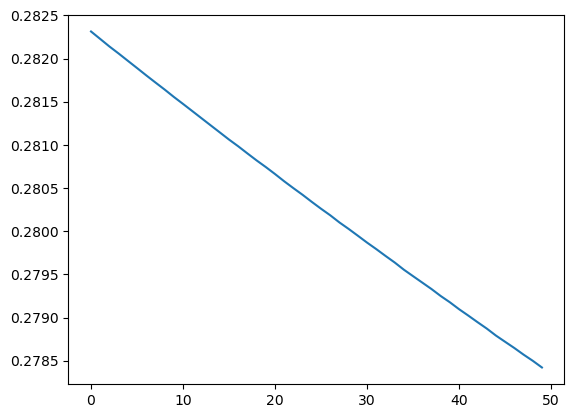

In [224]:
plt.plot(curve[-50:])

In [225]:
print(classification_report(ys_test, torch.argmax(model(Xs_test), 1)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.90      1032
           3       0.90      0.90      0.90      1010
           4       0.91      0.93      0.92       982
           5       0.89      0.86      0.87       892
           6       0.93      0.95      0.94       958
           7       0.92      0.91      0.92      1028
           8       0.87      0.87      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000


### Exercise 3.3: Evaluating our model

Write some code to plot the loss curve for your training run and evaluate the performance of your model on the test data. Play with the hyperparameters (e.g. learning rate) to try to get the best performance on the test set. Can you beat the stable baseline?

## Going Deeper

Now we will go (at least one layer) deeper to see if we can significantly improve on the baseline.

### Exercise 3.4: A 2-layer MLP
Define a new model with one hidden layer. Use the code you wrote above to train and evaluate this new model. Can you beat the baseline? You might need to train in two stages using different learning rates.

**Things to think about**:

+ It might be hard to beat (or even equal) the baseline with deeper networks. Why?
+ Is there something else we should be monitoring while training, especially for deep networks?

In [ ]:
# Your code here.